In [31]:
pip install -r "../../requirement.txt"

Note: you may need to restart the kernel to use updated packages.


In [32]:
import sys
import os
dirname = os.path.abspath('')
pardir = os.path.abspath(os.path.join(dirname, os.pardir))    
sys.path.append(os.path.join(dirname, 'tools/'))

from tools.DatasetExtraction import extract, extract_features
import tools.UsefulFunctions as uf
from tools.UsefulFunctions import Net
import l2o
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [33]:
#Constants

RANDOM_STATE = 42
VAL_SIZE = 0.2

## Data Preparation

In [34]:
#Extract dataset

name = 'big_dataset'

X, yID, dataset = extract(name)

dataset loaded
features loaded
labels loaded


In [35]:
#Split the dataset

Xs, ys, datasets = uf.split(X, yID, dataset, VAL_SIZE, RANDOM_STATE)

X_train, X_val = Xs
y_train, y_val = ys
dataset_train, dataset_val = datasets

In [36]:
#Encode labels and move to available GPU

classes = ('CMAES', 'PSO', 'Adam', 'LBFGSB', 'RandomSearch')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_train_enc, y_val_enc = uf.encode_y(ys, classes, device)

In [37]:
#Preprocess and scale features

X_train, X_val = uf.preprocess_X([X_train, X_val], device)

scaler = uf.TorchStandardScaler()
scaler.fit(X_train[:,:32])

X_train, X_val = uf.scale([X_train, X_val], scaler)

In [38]:
#Create tensor datasets and put them in loaders

b_size = 64

train_set = TensorDataset(X_train, y_train_enc)
val_set = TensorDataset(X_val, y_val_enc)

train_loader = DataLoader(train_set, batch_size=b_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=b_size)

## Net import/training

In [39]:
#Load best model to use
net = torch.load('ready_files/DL_best_model.pt', map_location=device)

##### To train the network uncomment the following 3 cells

In [40]:
# #Optional best net training
# 
# epochs = 10
# 
# n_layers = 5
# n_hidden_units = 591
# k_dropout = 0.12639042548968454
# lr = 0.0010760449398092603
# weight_decay = 4.2640526593435505e-06
# 
# net = Net(n_layers, n_hidden_units, k_dropout)
# net = net.to(device)
# 
# criterion = nn.CrossEntropyLoss()
# criterion = criterion.to(device)
# optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
# 
# train_loss_log = []
# train_acc_log = []
# 
# val_loss_log = []
# val_acc_log = []
# 
# early_stopper = uf.EarlyStopper(3, 1)
# 
# for epoch in tqdm(range(epochs)):
#     uf.train(train_loader,net,optimizer,criterion)
# 
#     train_loss, train_acc = uf.test(train_loader,net,criterion)
# 
#     train_loss_log.append(train_loss)
#     train_acc_log.append(train_acc)  
# 
#     val_loss, val_acc = uf.test(val_loader,net,criterion)
# 
#     val_loss_log.append(val_loss)
#     val_acc_log.append(val_acc) 
# 
#     if early_stopper.early_stop(val_acc):
#         print('\n Early stop')
#         break
# 
# print('\n Finished Training')

In [41]:
# #Show loss and accuracy after training
# 
# print(f'Training loss: {train_loss_log[-1]}')
# print(f'Validation loss: {val_loss_log[-1]}\n')
# 
# print(f'Training accuracy: {max(train_acc_log)}')
# print(f'Validation accuracy: {max(val_acc_log)}\n')

In [42]:
# #Plot training curves
# 
# start = 0
# 
# t = [float(i) for i in train_loss_log]
# v = [float(i) for i in val_loss_log]
# plt.plot(range(start, len(train_loss_log)), t[start:], label='train')
# plt.plot(range(start, len(val_loss_log)), v[start:], label='validation')
# plt.ylabel('Loss')
# plt.xlabel('Epochs')
# plt.grid()
# plt.legend()
# plt.show()
# 
# t = [float(i) for i in train_acc_log]
# v = [float(i) for i in val_acc_log]
# plt.plot(range(start, len(train_acc_log)), t[start:], label='train')
# plt.plot(range(start, len(val_acc_log)), v[start:], label='validation')
# plt.ylabel('Accuracy')
# plt.xlabel('Epochs')
# plt.grid()
# plt.legend()
# plt.show()

## Results

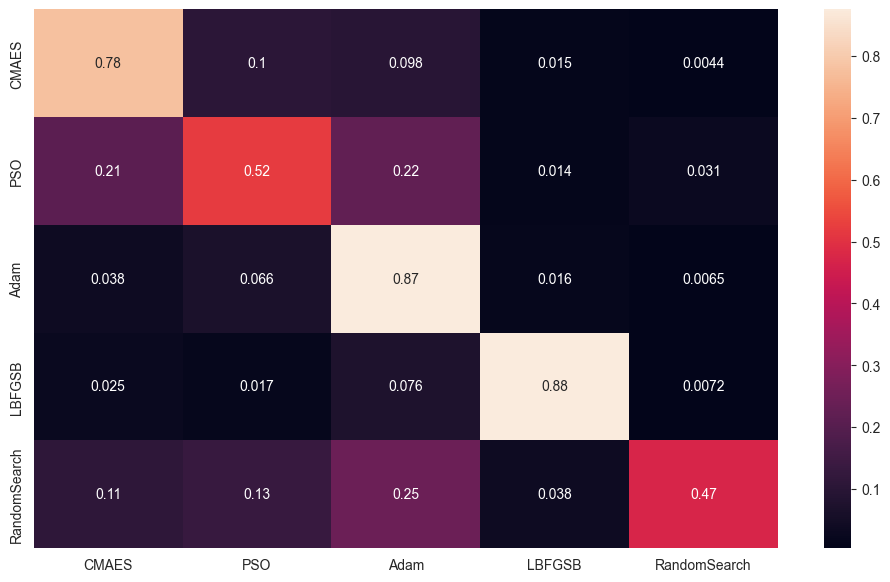

In [43]:
#Confusion matrix

true, predicted = uf.true_predicted(net, val_loader)
cf_matrix = confusion_matrix(true, predicted)
fig = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                    columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(fig, annot=True)
plt.show()

In [44]:
#KNN for comparison

KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train[:,30:].cpu(), y_train)
print(f'KNN Accuracy: {KNN.score(X_val[:,30:].cpu(), y_val)}')

KNN Accuracy: 0.5932721712538226


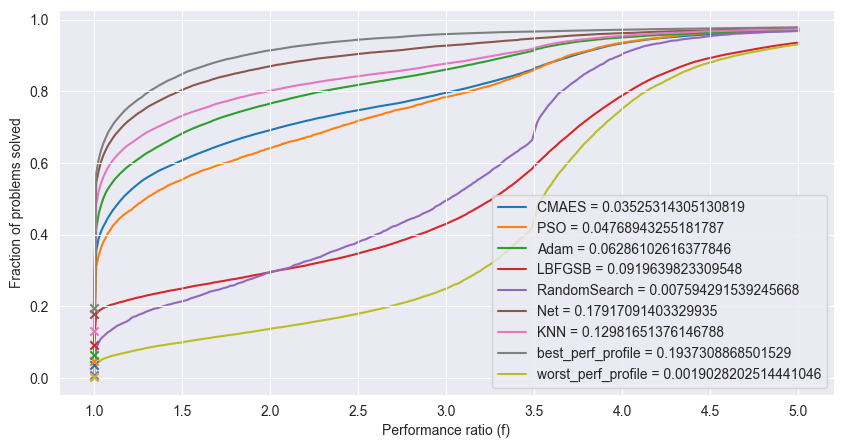

In [45]:
#Plot performance profiles

models = [(net, 'Net'), (KNN, 'KNN')]
strategies = [uf.YourStrategy(model, scaler, device, name) for model, name in models]

strategy_manager = l2o.StrategyManager(dataset_val, strategies)
performance_profiles = strategy_manager.compute_performance_profiles()
strategy_manager.plot()
plt.show()